In [2]:
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
from ephys import rasters
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import seaborn as sns
from importlib import reload
sns.set_context('poster')
sns.set_style('white')
%matplotlib inline
reload(sa)
reload(sc)

<module 'neuraltda.simpComp' from '/home/brad/code/NeuralTDA/neuraltda/simpComp.py'>

# Reproducing graph ML Estimation from De domnico


In [53]:
# generate a random graph:
plink = 0.05

N = 200
adj = np.random.rand(N, N)
adj = (adj + adj.T)/2.0
adjData = (adj < plink).astype(int)
adjData = adjData - np.diag(np.diag(adjData))
Edata = sc.simplicialChainGroups(sc.adjacency2maxsimp(adjData, range(N)))
Ldata = sc.compute_laplacian(Edata, 0)

Ddata = np.diag(np.sum(adjData, axis=0))
Ldata_graph = Ddata - adjData
#print(np.amax(np.absolute(Ldata-Ldata_graph)))
#print(Ldata_graph)
#print(Ldata)
#print(Ldata-Ldata_graph)
#print(Ddata)
#print(adjData)

In [54]:
def loss(p, rdata, beta):
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Esample = sc.simplicialChainGroups(sc.adjacency2maxsimp(adj, range(N)))
    Lsamp = sc.compute_laplacian(Esample, 0)
    rsamp = sc.densityMatrix(Lsamp, beta)
    return sc.KLdivergence(rdata, rsamp)

def loss_matlog(p, rdata, beta):
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Esample = sc.simplicialChainGroups(sc.adjacency2maxsimp(adj, range(N)))
    Lsamp = sc.compute_laplacian(Esample, 0)
    rsamp = sc.densityMatrix(Lsamp, beta)
    return sc.KLdivergence_matrixlog(rdata, rsamp)

def loss_matlog_graphadj(p, rdata, beta):
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Lsamp = np.diag(np.sum(adj, axis=0)) - adj
    rsamp = sc.densityMatrix(Lsamp, beta)
    return sc.KLdivergence_matrixlog(rdata, rsamp)

c = 0.2899465652721812


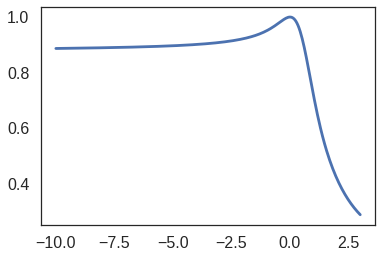

In [36]:

beta = -0.5

cs = []
betas = np.linspace(-10, 3, 300)
for beta in betas:
    rdata = sc.densityMatrix(Ldata_graph, beta)
    c = sc.Entropy(rdata)/(np.log(N)/np.log(2.0))
    cs.append(c)
    
plt.plot(betas, cs)
print("c = {}".format(c))

0.99201174932


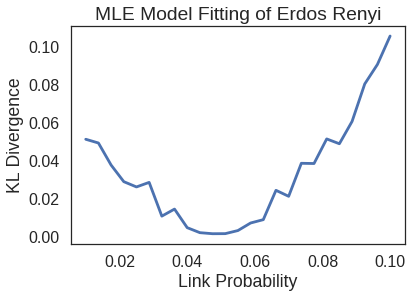

In [57]:
beta = 2.5
beta = -0.25
kl = []
rdata = sc.densityMatrix(Ldata, beta)
ps = np.linspace(0.01, 0.1, 25)
c = sc.Entropy(rdata)/(np.log(N)/np.log(2.0))
print(c)
for p in ps:
    #kl.append(loss_matlog(p, rdata, beta))
    kl.append(loss(p, rdata, beta))
    #kl.append(loss_matlog_graphadj(p, rdata, beta))
    
plt.plot(ps, kl)
plt.xlabel('Link Probability')
plt.ylabel('KL Divergence')
plt.title('MLE Model Fitting of Erdos Renyi')

0.025
0.0265306122449
0.0280612244898
0.0295918367347
0.0311224489796
0.0326530612245
0.0341836734694
0.0357142857143
0.0372448979592
0.0387755102041
0.040306122449
0.0418367346939
0.0433673469388
0.0448979591837
0.0464285714286
0.0479591836735
0.0494897959184
0.0510204081633
0.0525510204082
0.0540816326531
0.055612244898
0.0571428571429
0.0586734693878
0.0602040816327
0.0617346938776
0.0632653061224
0.0647959183673
0.0663265306122
0.0678571428571
0.069387755102
0.0709183673469
0.0724489795918
0.0739795918367
0.0755102040816
0.0770408163265
0.0785714285714
0.0801020408163
0.0816326530612
0.0831632653061
0.084693877551
0.0862244897959
0.0877551020408
0.0892857142857
0.0908163265306
0.0923469387755
0.0938775510204
0.0954081632653
0.0969387755102
0.0984693877551
0.1


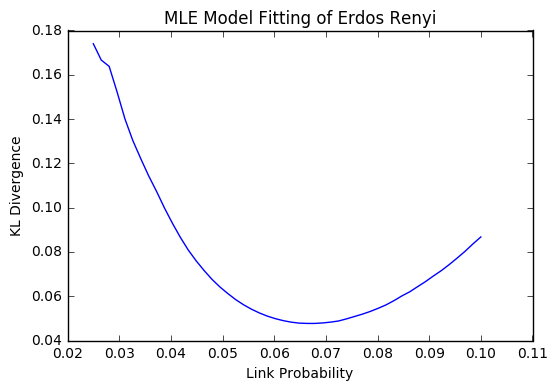

In [59]:
def loss(p, beta):
    
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Esample = sc.simplicialChainGroups(sc.adjacency2maxsimp(adj, range(N)))
    Edata = sc.simplicialChainGroups(sc.adjacency2maxsimp(adjData, range(N)))
    Lsamp = sc.laplacian(sc.boundaryOperatorMatrix(Esample), 0)
    Ldata = sc.laplacian(sc.boundaryOperatorMatrix(Edata), 0)
    rsamp = sc.densityMatrix(Lsamp, beta)
    rdata = sc.densityMatrix(Ldata, beta)
    return sc.KLdivergence(rdata, rsamp)

kl = []
kl_p = []
nsamples = 10
ps = np.linspace(0.025, 0.1, 50)
for p in ps:
    print(p)
    for n in range(nsamples):
        kl_p.append(loss(p, 0.25))
    kl.append(np.mean(kl_p))
    
plt.plot(ps, kl)
plt.xlabel('Link Probability')
plt.ylabel('KL Divergence')
plt.title('MLE Model Fitting of Erdos Renyi')

In [187]:
beta = 0.1
c = 0.25
Edata = sc.simplicialChainGroups(sc.adjacency2maxsimp(adjData, range(N)))
Ldata = sc.laplacian(sc.boundaryOperatorMatrix(Edata), 0)
rdata = sc.densityMatrix(Ldata, beta)
entData = sc.Entropy(rdata, beta)

#determine beta
f = lambda b: -sc.Entropy(rdata, b) / N - c*b
betastar = brentq(f, 0.001, 1.5)
betastar

0.15189116598734353

0.025
0.0265306122449
0.0280612244898
0.0295918367347
0.0311224489796
0.0326530612245
0.0341836734694
0.0357142857143
0.0372448979592
0.0387755102041
0.040306122449
0.0418367346939
0.0433673469388
0.0448979591837
0.0464285714286
0.0479591836735
0.0494897959184
0.0510204081633
0.0525510204082
0.0540816326531
0.055612244898
0.0571428571429
0.0586734693878
0.0602040816327
0.0617346938776
0.0632653061224
0.0647959183673
0.0663265306122
0.0678571428571
0.069387755102
0.0709183673469
0.0724489795918
0.0739795918367
0.0755102040816
0.0770408163265
0.0785714285714
0.0801020408163
0.0816326530612
0.0831632653061
0.084693877551
0.0862244897959
0.0877551020408
0.0892857142857
0.0908163265306
0.0923469387755
0.0938775510204
0.0954081632653
0.0969387755102
0.0984693877551
0.1


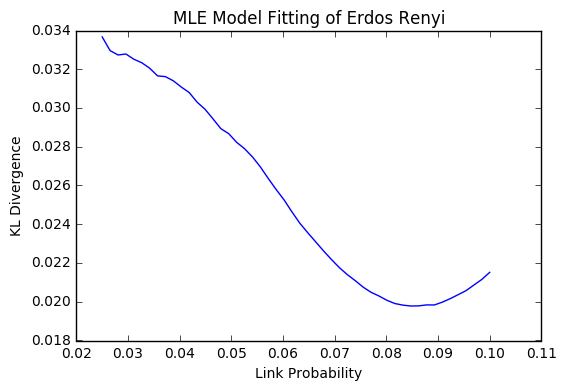

In [188]:
def loss(p, beta):
    N = 200
    adj = np.random.rand(N, N)
    adj = (adj + adj.T)/2.0
    adj = (adj < p).astype(int)
    Esample = sc.simplicialChainGroups(sc.adjacency2maxsimp(adj, range(N)))
    Lsamp = sc.laplacian(sc.boundaryOperatorMatrix(Esample), 0)
    rsamp = sc.densityMatrix(Lsamp, beta)
    return sc.KLdivergence(rdata, rsamp)

kl = []
kl_p = []
nsamples = 10
ps = np.linspace(0.025, 0.1, 50)
for p in ps:
    print(p)
    for n in range(nsamples):
        kl_p.append(loss(p, betastar))
    kl.append(np.mean(kl_p))
    
plt.plot(ps, kl)
plt.xlabel('Link Probability')
plt.ylabel('KL Divergence')
plt.title('MLE Model Fitting of Erdos Renyi')

In [35]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.02
b = 0.15
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


In [36]:
nsamples2 = 10
def loss(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ecombined = sc.simplexUnion(Emodel, Edata)
        
        Lsamp = sc.laplacian(sc.boundaryOperatorMatrix(Emodel), 1)
        Ldata = sc.laplacian(sc.boundaryOperatorMatrix(Edata), 1)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    return np.mean(KLsave)

In [281]:
KL=[]
X = np.linspace(0.01, 0.1, 30)

for x in X:
    KL.append(loss(x, 0.15))

ValueError: operands could not be broadcast together with shapes (176,) (15,) 

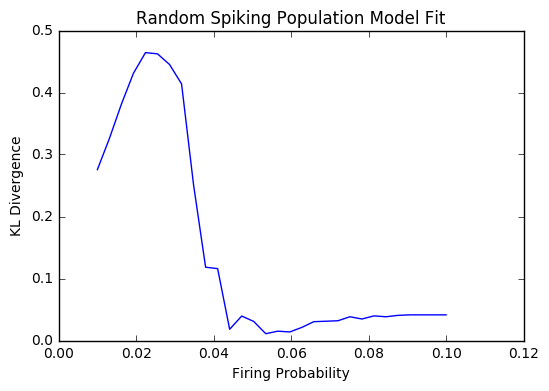

In [279]:
plt.plot(X, KL)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Random Spiking Population Model Fit')

In [137]:
ez = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
ey = np.array([[0, 0, 1], [0, 0, 0], [-1, 0, 0]])
ex = np.array([[0, 0, 0], [0, 0, 1], [0, -1, 0]])

In [157]:
plink = 0.5
N = 500
adjMats= []
lapMats = []
for n in range(3):
    adj = np.random.rand(N, N)
    w = np.random.randn(N, N)
    adj = (adj + adj.T)/2.0
    w = (w+w.T)/2.0
    adjData = (adj < plink).astype(int)
    adjData = np.multiply(adjData, w)
    adjMats.append(adjData)
    lapMats.append(sc.graphLaplacian(adjData))

In [159]:
def mat(i, j):
    return adjMats[0][i,j]*ex + adjMats[1][i,j]*ey + adjMats[2][i,j]*ez
def lap(i, j):
    return lapMats[0][i,j]*ex + lapMats[1][i,j]*ey + lapMats[2][i,j]*ez

In [41]:
nsamples2 = 25
d = 1
def loss(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ecombined = sc.simplexUnion(Emodel, Edata)
        Ddata = sc.maskedBoundaryOperatorMatrix(Ecombined, Edata)
        Dsamp = sc.maskedBoundaryOperatorMatrix(Ecombined, Emodel)
        
        Lsamp = sc.laplacian(Dsamp, d)
        Ldata = sc.laplacian(Ddata, d)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ddata = sc.boundaryOperatorMatrix(Edata)
        Dsamp = sc.boundaryOperatorMatrix(Emodel)
        Lsamp = sc.laplacian(Dsamp, d)
        Ldata = sc.laplacian(Ddata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)


In [44]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 200
nwin = 1000
a = 0.001
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

In [45]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.0005, 0.007, 25)

for t in range(ntrials):
    print(t)
    KL=[]
    KLerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new(x, 0.15)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.0005
0.000770833333333
0.00104166666667
0.0013125
0.00158333333333
0.00185416666667
0.002125
0.00239583333333
0.00266666666667
0.0029375
0.00320833333333
0.00347916666667
0.00375
0.00402083333333
0.00429166666667
0.0045625
0.00483333333333
0.00510416666667
0.005375
0.00564583333333
0.00591666666667
0.0061875
0.00645833333333
0.00672916666667
0.007


In [53]:
print(np.mean(est_save))
np.std(est_save)

0.00518367346939


0.00036734693877551008

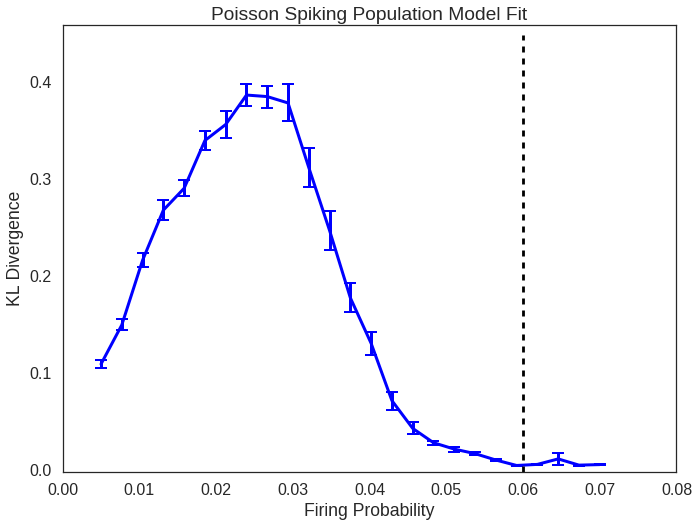

In [30]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, 0.45, 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

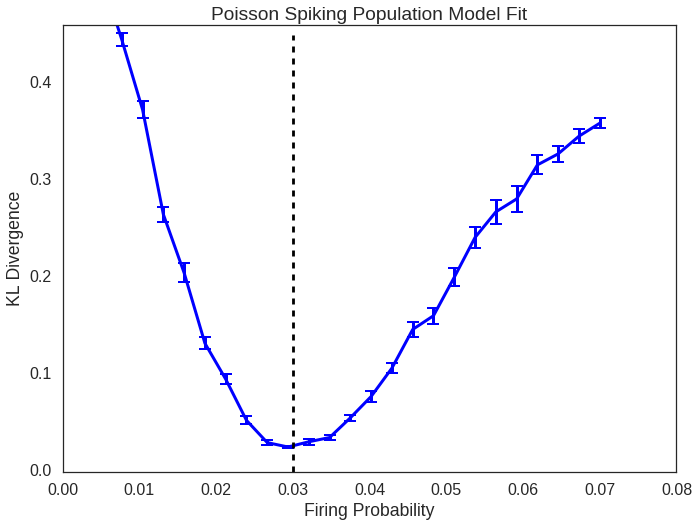

In [21]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, 0.45, 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

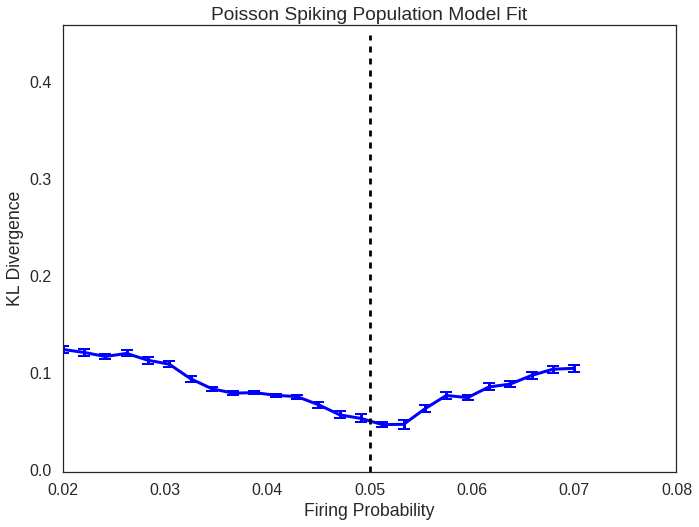

In [63]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, 0.45, 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

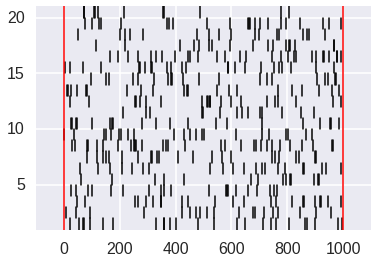

In [3]:
# make rasters of the original and best fit.
spikesorig = np.squeeze(binMatsamples)
def convert_to_raster_data(binmat):
    (ncells, nt) = np.shape(binmat)
    raster_data = []
    sp = np.transpose(np.nonzero(binmat))
    for cell in range(ncells):
        raster_data.append(sp[sp[:, 0]==cell][:, 1])
    return raster_data
rasterdatorig = convert_to_raster_data(spikesorig)
plt.figure()
rasters.do_raster(rasterdatorig, [-100, 1100], [0, 1000])

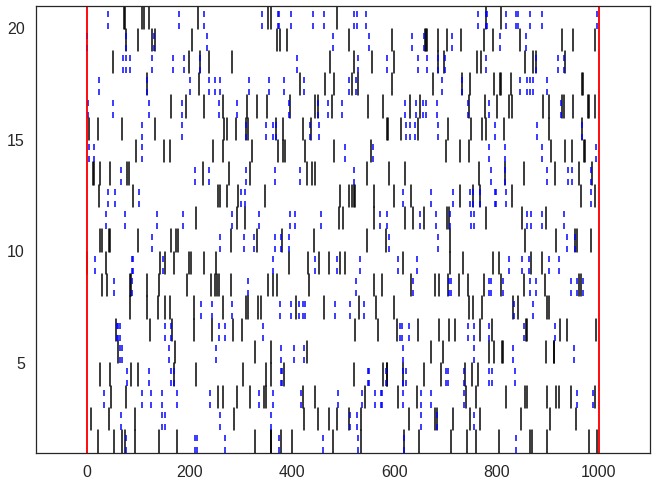

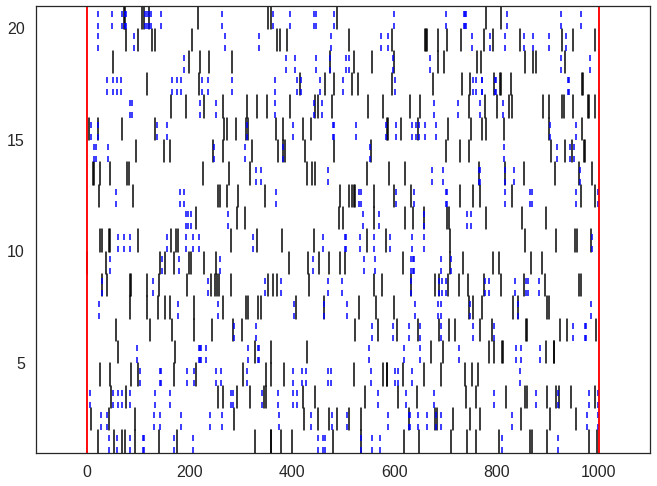

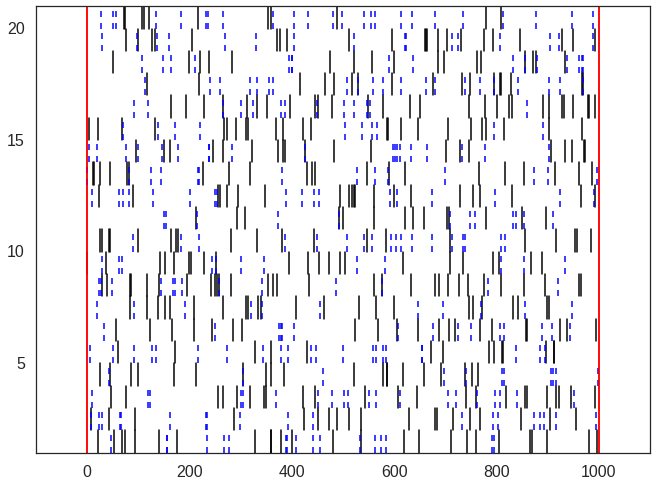

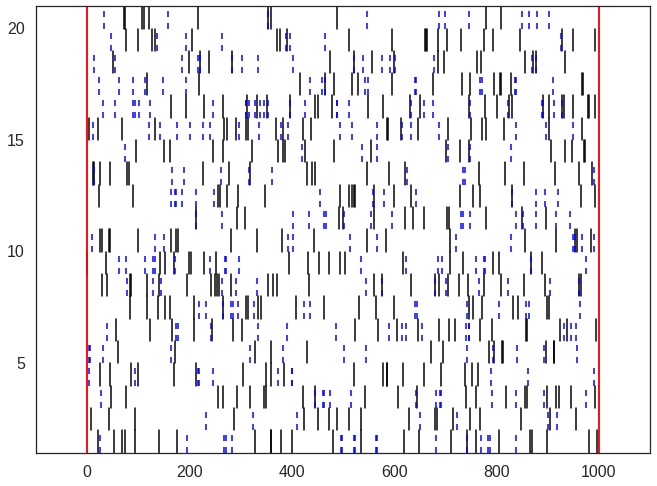

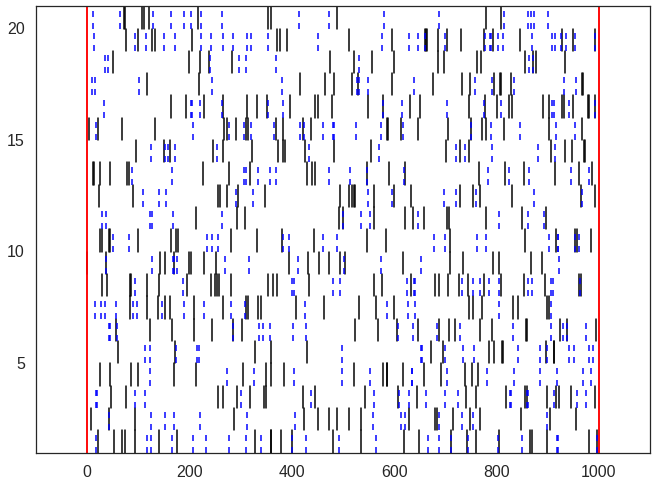

In [12]:
a = 0.015
probs = (a*np.ones((ncells, 1)))
KLsave=[]
nsamples2 = 5
for n in range(5):
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples2 = np.greater(probmat, samples).astype(int)
    newrast = convert_to_raster_data(np.squeeze(binMatsamples2[:, :, n]))
    plt.figure(figsize = (11, 8))
    rasters.do_raster(rasterdatorig, [-100, 1100], [0, 1000])
    rasters.do_raster(newrast, [-100, 1100], [0, 1000], spike_color='b--')
    plt.savefig('/home/brad/SpikeFitting_{}.pdf'.format(n), format='pdf')

In [51]:
#mean squared difference
nsamples2 = 25
def lossMSE(a):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    MSEsave=[]
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples2 = np.greater(probmat, samples).astype(int)
    for ind in range(nsamples2):
        mse = np.sum(np.square(binMatsamples2[:, :, ind] - spikesorig))
        MSEsave.append(mse)
    m = np.mean(MSEsave)
    std = np.std(MSEsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

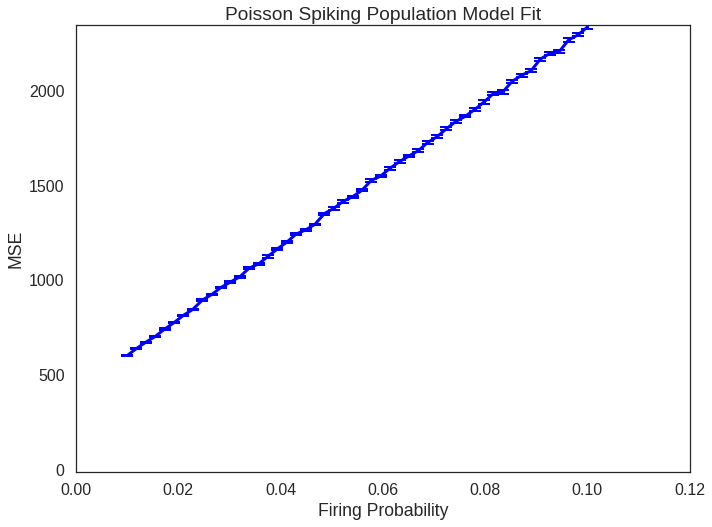

In [55]:
MSE=[]
MSEerr = []
X = np.linspace(0.01, 0.1, 50)

for x in X:
    
    (m, stderr) = lossMSE(x)
    MSE.append(m)
    MSEerr.append(stderr)
    #$print(x)
    
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, MSE, yerr=MSEerr, linewidth=3, capsize=6, capthick=2, fmt='b')
plt.ylim(0, max(MSE)+10)
plt.plot(a*np.ones((20, 1)), np.linspace(0, 0.45, 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('MSE')
plt.title('Poisson Spiking Population Model Fit')

In [53]:
MSE

[616.67999999999995,
 619.39999999999998,
 624.0,
 638.39999999999998,
 644.88,
 648.44000000000005,
 655.51999999999998,
 668.79999999999995,
 673.63999999999999,
 683.48000000000002,
 688.72000000000003,
 696.75999999999999,
 706.60000000000002,
 710.12,
 725.0,
 728.48000000000002,
 735.91999999999996,
 746.36000000000001,
 747.12,
 756.20000000000005,
 774.20000000000005,
 768.63999999999999,
 782.55999999999995,
 787.36000000000001,
 799.48000000000002,
 804.20000000000005,
 817.67999999999995,
 817.75999999999999,
 825.0,
 835.48000000000002,
 839.27999999999997,
 854.03999999999996,
 862.0,
 870.96000000000004,
 874.67999999999995,
 885.63999999999999,
 894.24000000000001,
 892.91999999999996,
 908.79999999999995,
 921.44000000000005,
 925.15999999999997,
 934.27999999999997,
 938.75999999999999,
 942.55999999999995,
 954.55999999999995,
 962.88,
 970.72000000000003,
 976.96000000000004,
 989.88,
 997.75999999999999]

In [287]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.05
b = 0.05
probs = (a*np.ones((ncells, 1)))
nsamples = 2
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]
Emodel = SCGs[1]


In [290]:

Ecombined = sc.simplexUnion(Emodel, Edata)
Ddata = sc.maskedBoundaryOperatorMatrix(Ecombined, Edata)
Dsamp = sc.maskedBoundaryOperatorMatrix(Ecombined, Emodel)
        
Lsamp = sc.laplacian(Dsamp, 0)
Ldata = sc.laplacian(Ddata, 0)
rsamp = sc.densityMatrix(Lsamp, beta)
        
rdata = sc.densityMatrix(Ldata, beta)

In [14]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 10
nwin = 1000
a = 0.02
b = 0.02
probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
nsamples = 1
samples = np.random.rand(2*ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)
np.random.shuffle(binMatsamples)



# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    mat = binMatsamples[:, :, ind]
    mat = np.random.permutation(mat.T)
    mat = mat.T
    print(mat.shape)
    msimps = sc.binarytomaxsimplex(binMat=mat, rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


(20, 1000)


In [26]:
d = 1
nsamples2 = 10
def loss(a, b, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
    KLsave=[]
    samples = np.random.rand(2*ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ecombined = sc.simplexUnion(Emodel, Edata)
        Ddata = sc.maskedBoundaryOperatorMatrix(Ecombined, Edata)
        Dsamp = sc.maskedBoundaryOperatorMatrix(Ecombined, Emodel)
        
        Lsamp = sc.laplacian(Dsamp, d)
        Ldata = sc.laplacian(Ddata, d)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    return np.mean(KLsave)

In [27]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 10
nwin = 1000
a = 0.02
b = 0.02
probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
nsamples = 1
samples = np.random.rand(2*ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)
np.random.shuffle(binMatsamples)



# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    mat = binMatsamples[:, :, ind]
    mat = np.random.permutation(mat.T)
    mat = mat.T
    print(mat.shape)
    msimps = sc.binarytomaxsimplex(binMat=mat, rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]

KL=[]
nKL = 40
X = np.linspace(0.005, 0.05, nKL)

for x in X:
    print(x)
    for y in X:
        KL.append(loss(x,y, 0.15))
KL = np.reshape(KL, (nKL,nKL))

(20, 1000)
0.005
0.00615384615385
0.00730769230769
0.00846153846154
0.00961538461538
0.0107692307692
0.0119230769231
0.0130769230769
0.0142307692308
0.0153846153846
0.0165384615385
0.0176923076923
0.0188461538462
0.02
0.0211538461538
0.0223076923077
0.0234615384615
0.0246153846154
0.0257692307692
0.0269230769231
0.0280769230769
0.0292307692308
0.0303846153846
0.0315384615385
0.0326923076923
0.0338461538462
0.035
0.0361538461538
0.0373076923077
0.0384615384615
0.0396153846154
0.0407692307692
0.0419230769231
0.0430769230769
0.0442307692308
0.0453846153846
0.0465384615385
0.0476923076923
0.0488461538462
0.05


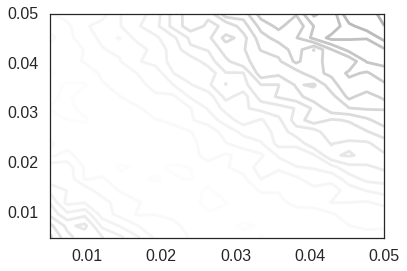

In [18]:
x, y = np.meshgrid(np.linspace(0.005, 0.05, 20), np.linspace(0.005, 0.05, 20))
levels = np.arange(0, 1, 0.025)
plt.contour(x, y, KL, levels=levels)

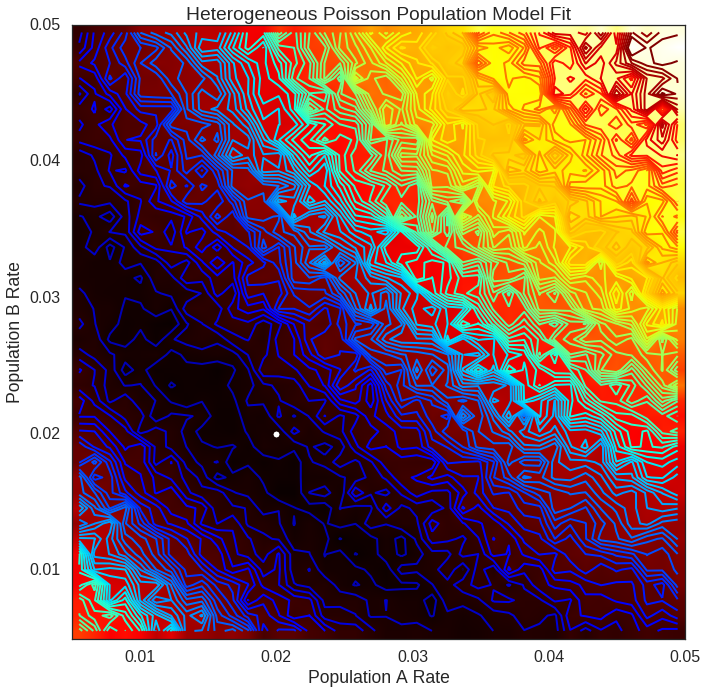

In [33]:
plt.figure(figsize=(11,11))

plt.plot([a], [b], 'w.')
plt.plot([b], [a], 'w.')
im = plt.imshow(KL, interpolation='bilinear', origin='lower',
                cmap='hot', extent=(0.005, 0.05, 0.005, 0.05))
levels = np.arange(0, 0.4, 0.005)
CS = plt.contour(KL, origin='lower', levels=levels, linewidths=2,extent=(0.005, 0.05, 0.005, 0.05), cmap='jet')
plt.title('Heterogeneous Poisson Population Model Fit')
plt.xlabel('Population A Rate')
plt.ylabel('Population B Rate')
#plt.savefig('/Users/brad/twopopulationpoisson.pdf', format='pdf')

In [57]:
# try to reproduce given structure

targetMaxSimps = [(1,2), (2,3), (3,4), (4,5), (1,5)]

initweights = np.random.randn(5,5)/np.sqrt(5)

In [96]:
## setup parameters and state variables
T       = 50                  # total time to simulate (msec)
dt      = 0.125               # simulation time step (msec)
time    = np.arange(0, T+dt, dt) # time array
t_rest  = 0                   # initial refractory time
ncells = 5

## LIF properties
Vm      = np.zeros((ncells, len(time)))    # potential (V) trace over time
Rm      = 1                   # resistance (kOhm)
Cm      = 10                  # capacitance (uF)
tau_m   = Rm*Cm               # time constant (msec)
tau_ref = 0                   # refractory period (msec)
Vth     = 1                   # spike threshold (V)
V_spike = 0                 # spike reset (V)

## Stimulus
I       = 1.5                 # input current (A)

def spike(W, T):
    ## iterate over each time step
    dt      = 0.125               # simulation time step (msec)
    time    = np.arange(0, T+dt, dt) # time array
    Vm      = np.zeros((ncells, len(time)))    # potential (V) trace over time
    binmat = np.zeros((ncells, len(time)))
    for i, t in enumerate(time):
        if t > 0:
            Vm[:, i] = Vm[:, i-1] + (-Vm[:, i-1] + np.random.randn(5, 1)) / tau_m * dt
        if (Vm[:, i] >= Vth).any():
            binmat[:, i] = (Vm[:, i] >= Vth).astype(int)
            Vm[:, i] = np.dot(W, binmat[:, i]*Rm)
            Vm[:, i] += np.multiply(V_spike, (Vm[:, i] >= Vth).astype(int))
    return binmat, Vm

In [97]:
ps, Vm = spike(initweights, 50)
Vm

ValueError: could not broadcast input array from shape (5,5) into shape (5)

In [92]:
np.random.randn(ncells, 1)

array([[ 0.12635919],
       [ 0.08996373],
       [ 0.11467204],
       [ 0.47766722],
       [-1.16082666]])

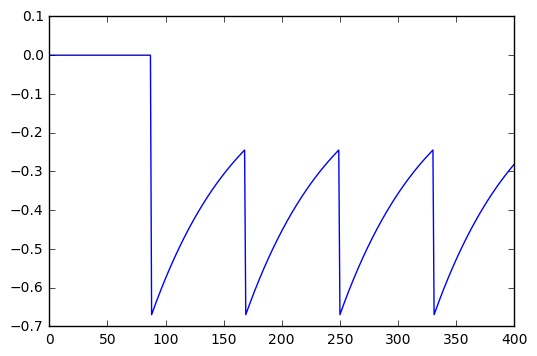

In [82]:
plt.plot(Vm[3, :])

# Try summing all the divergences across dimensions

In [2]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 10
nwin = 1000
a = 0.02
b = 0.05
probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
nsamples = 1
samples = np.random.rand(2*ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)
np.random.shuffle(binMatsamples)



# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    mat = binMatsamples[:, :, ind]
    mat = np.random.permutation(mat.T)
    mat = mat.T
    print(mat.shape)
    msimps = sc.binarytomaxsimplex(binMat=mat, rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


(20, 1000)


In [ ]:
# Find beta of model in each dimension



In [3]:
d = 1
maxd = 3
nsamples2 = 5
def loss(a, b, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = np.vstack((a*np.ones((ncells, 1)), b*np.ones((ncells, 1))))
    KLsave=[]
    samples = np.random.rand(2*ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        Ecombined = sc.simplexUnion(Emodel, Edata)
        Ddata = sc.maskedBoundaryOperatorMatrix(Ecombined, Edata)
        Dsamp = sc.maskedBoundaryOperatorMatrix(Ecombined, Emodel)
        diver = 0
        for d in range(maxd):
            try:
                Lsamp = sc.laplacian(Dsamp, d)
                Ldata = sc.laplacian(Ddata, d)
                rsamp = sc.densityMatrix(Lsamp, beta)
                rdata = sc.densityMatrix(Ldata, beta)
                diver = diver + sc.KLdivergence(rdata, rsamp)
            except:
                diver = diver +0
            
        
        KLsave.append(diver)
    return np.mean(KLsave)

In [4]:
KL=[]
X = np.linspace(0.01, 0.1, 20)

for x in X:
    print(x)
    for y in X:
        KL.append(loss(x,y, 0.15))
KL = np.reshape(KL, (20,20))

0.01
0.0147368421053
0.0194736842105
0.0242105263158
0.0289473684211
0.0336842105263
0.0384210526316
0.0431578947368
0.0478947368421
0.0526315789474
0.0573684210526
0.0621052631579
0.0668421052632
0.0715789473684
0.0763157894737
0.0810526315789
0.0857894736842
0.0905263157895
0.0952631578947
0.1


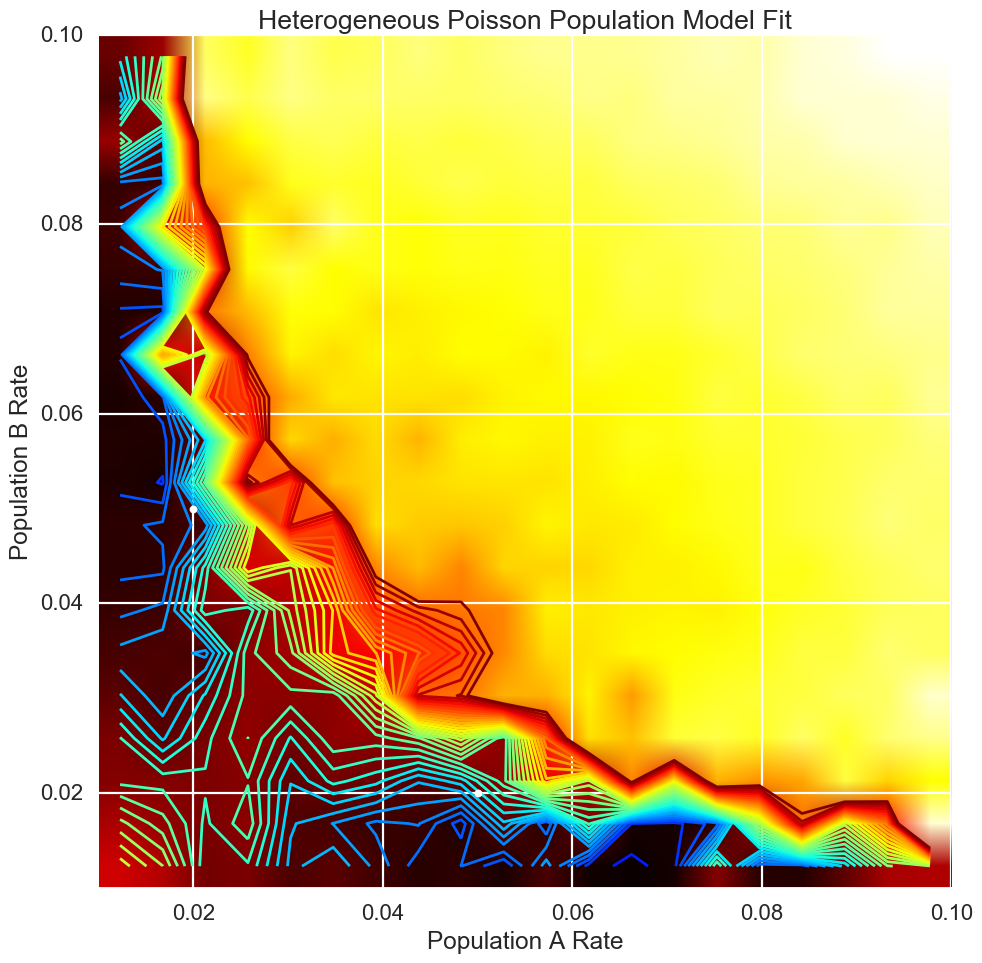

In [7]:
plt.figure(figsize=(11,11))

plt.plot([a], [b], 'w.')
plt.plot([b], [a], 'w.')
im = plt.imshow(KL, interpolation='bilinear', origin='lower',
                cmap='hot', extent=(0.01, 0.1, 0.01, 0.1))
#levels = np.arange(0, 0.1, 0.01)
CS = plt.contour(KL, origin='lower', levels=levels, linewidths=2,extent=(0.01, 0.1, 0.01, 0.1), cmap='jet')
plt.title('Heterogeneous Poisson Population Model Fit')
plt.xlabel('Population A Rate')
plt.ylabel('Population B Rate')
#plt.savefig('/Users/brad/twopopulationpoisson.pdf', format='pdf')

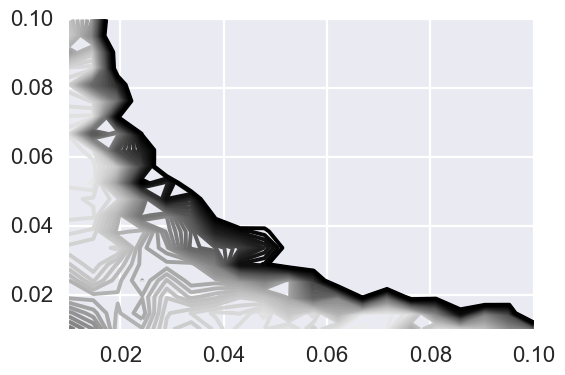

In [6]:
x, y = np.meshgrid(np.linspace(0.01, 0.1, 20), np.linspace(0.01, 0.1, 20))
levels = np.arange(0, 1, 0.025)
plt.contour(x, y, KL, levels=levels)

In [62]:
ms1 = [(1,2,8), (4,8)]
ms2 = [(1,2,4,5)]



def maskedLaplacians(ms1, ms2,d):

    Ems1 = sc.simplicialChainGroups(ms1)
    Ems2 = sc.simplicialChainGroups(ms2)
    Ecombined = sc.simplexUnion(Ems1, Ems2)
    Dms1 = sc.maskedBoundaryOperatorMatrix(Ecombined, Ems1)
    Dms2 = sc.maskedBoundaryOperatorMatrix(Ecombined, Ems2)
    print(Dms1[d+1])
    print(Dms2[d+1])
    Lms1 = sc.laplacian(Dms1, d)
    Lms2 = sc.laplacian(Dms2, d)
    return (Lms1, Lms2)

rms1 = sc.densityMatrix(Lms1, beta)
rms2 = sc.densityMatrix(Lms2, beta)
print(rms1)
print(rms2)

[[ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 1.  1.  0.  0.  0.]
 [-1.  0.  0.  1.  0.]
 [ 0. -1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.]
 [ 0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.]]
[[  1.13090490e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   1.09748161e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.09748161e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.13096126e-01
    0.00000000e+00   0.00000000e+0

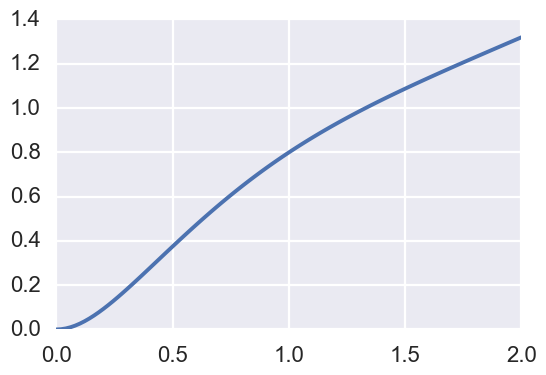

In [63]:
sv = []
b = np.linspace(0, 2, 100)
for beta in b:
    rms1 = sc.densityMatrix(Lms1, beta)
    rms2 = sc.densityMatrix(Lms2, beta)
    sv.append(sc.JSdivergence(rms1, rms2))
plt.plot(b, sv)

In [51]:
print(np.dot(Dms1[2], Dms1[2].T))
np.dot(Dms1[1].T, Dms1[1])

[[ 1. -1.  0.  1.  0.]
 [-1.  1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.]]


array([[ 2.,  1.,  0., -1.,  0.],
       [ 1.,  2.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [52]:
Lms1

array([[ 3.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

Graph stuff

In [13]:
import pygraphviz as pg
import itertools

def build_graph_recursive(graph, cell_group, parent_name):

    cell_group_name = ''.join(cell_group)
    graph.add_node(cell_group_name)
    n_cells_in_group = len(cell_group)

    graph.add_edge(cell_group_name, parent_name)
    #graph.edge[cell_group_name][parent_name]['name'] = cell_group_name+parent_name
    
    if n_cells_in_group > 1:
        for subgrp in itertools.combinations(cell_group, n_cells_in_group-1):
            build_graph_recursive(graph, subgrp, cell_group_name)

    return graph


def build_graph_from_cell_groups(cell_groups):

    graph = pg.AGraph()
    prev='A'
    for group in cell_groups:
        group_s = [str(s)+'-' for s in sorted(group)]
        cell_group_name = ''.join(group_s)
        graph = build_graph_recursive(graph, group_s, 'A')
        graph.add_edge(prev, cell_group_name)
        prev=cell_group_name

    return graph



In [16]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 100
a = 0.05
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)
binMat = binMatsamples[:, :, 0]
maxsimps = sc.binarytomaxsimplex(binMat)
test = build_graph_from_cell_groups(maxsimps)
test.layout(prog='dot')
test.draw('test.png')

# Brian stuff

INFO       No numerical integration method specified for group 'neurongroup', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]


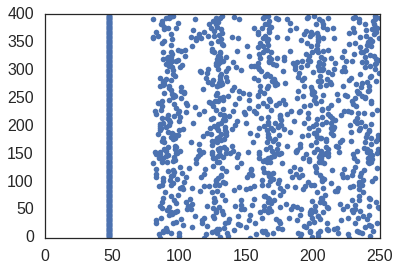

In [12]:
from brian2 import *
eqs = '''
dv/dt  = (ge+gi-(v+49*mV))/(20*ms) : volt
dge/dt = -ge/(5*ms)                : volt
dgi/dt = -gi/(10*ms)               : volt
'''
P = NeuronGroup(400, eqs, threshold='v>-50*mV', reset='v=-60*mV')
P.v = -60*mV
Pe = P[:320]
Pi = P[320:]
Ce = Synapses(Pe, P, on_pre='ge+=1.62*mV')
Ce.connect(p=0.02)
Ci = Synapses(Pi, P, on_pre='gi-=9*mV')
Ci.connect(p=0.02)
M = SpikeMonitor(P)
run(0.25*second)
plot(M.t/ms, M.i, '.')
show()

In [14]:
M.t



<spikemonitor.t: array([  47.9,   47.9,   47.9, ...,  249.4,  249.5,  249.9]) * msecond>